Epoch 1/30


C:\Users\Sunny\new\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2138/2138 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.6220 - auc: 0.5019 - loss: 0.6651 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9571 - learning_rate: 0.0010
Epoch 2/30
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6265 - auc: 0.5000 - loss: 0.6610 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 3/30
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6247 - auc: 0.5370 - loss: 0.6595 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 4/30
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6256 - auc: 0.5840 - loss: 0.6510 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9726 - learning_rate: 0.0010
Epoch 5/30
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6236 - auc: 0.5885 - loss: 0.6509 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 6/30
2138/2138 ━━━━━━━━━━━━━━━━━━━

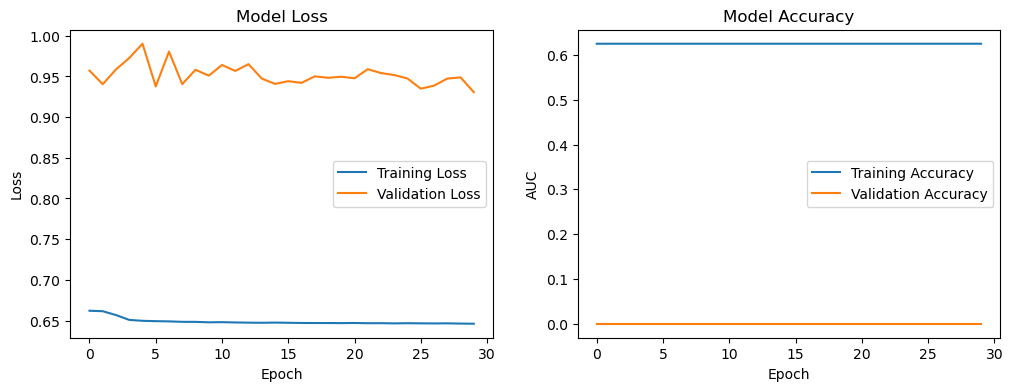

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load and preprocess data
updated_merged_data = pd.read_csv('updated_merged_final_rounded.csv')

# Preprocessing
scaler = MinMaxScaler()
updated_merged_data[['age', 'icu_stay_hours']] = scaler.fit_transform(
    updated_merged_data[['age', 'icu_stay_hours']]
)

# Create features and target
x = updated_merged_data[['age', 'icu_stay_hours']].values
y = updated_merged_data['ventilation_status_flag'].values

# Split data before SMOTE
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Reshape for LSTM
x_train_resampled = x_train_resampled.reshape((x_train_resampled.shape[0], 1, x_train_resampled.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Modified model architecture
model = Sequential([
    LSTM(32, input_shape=(1, 2), return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile with modified metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train with modified parameters
history = model.fit(
    x_train_resampled, y_train_resampled,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.0001
        )
    ],
    verbose=1
)

# Evaluate
y_pred_proba = model.predict(x_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nModel Performance:")
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()